In [2]:
#load packages
import numpy as np
import tensorflow as tf
import pickle as pl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Load Datasets
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
tf.reset_default_graph()

#Function to create generator and discrimninator inputs

def input_mnist(input_size, z_size):
    
    input_real = tf.placeholder(tf.float32,[None, input_size])
    
    input_gen = tf.placeholder(tf.float32, [None, z_size])
    
    
    return input_real, input_gen
    
    
    

In [5]:
#Function to create generator forward pass

def generator_forward(gen, input_size, n_units, reuse, alpha = 0.01):
    
    
    with tf.variable_scope('generator', reuse = reuse):
        
        hidden = tf.contrib.layers.fully_connected(gen, n_units, activation_fn = None)
        
        hidden = tf.maximum(alpha * hidden, hidden)
        
        logits = tf.contrib.layers.fully_connected(hidden, input_size, activation_fn = None)
        
        out = tf.nn.tanh(logits)
        
        return out
    

In [6]:
#Function to create discriminator forward pass

def discriminator_forward(x, n_units, reuse, alpha = 0.01):
    
    
    with tf.variable_scope('discriminator', reuse = reuse):
        
        hidden = tf.contrib.layers.fully_connected(x, n_units, activation_fn = None)
        
        hidden = tf.maximum(alpha * hidden, hidden)
        
        logits = tf.contrib.layers.fully_connected(hidden, 1, activation_fn = None)
        
        out = tf.nn.sigmoid(logits)
        
        return logits, out
    

In [7]:
#Defining model paramaters for tensorflow graph
input_size = 784
z_size = 100
g_hidden_size = 256
d_hidden_size = 256
smoothing = 0.1

In [8]:
#Building graph parameters
tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():
    
    input_real, input_gen = input_mnist(input_size, z_size)
    
    Gout = generator_forward(input_gen, input_size, g_hidden_size, reuse = False, alpha = 0.01)
    
    D_logits_real, D_out_real = discriminator_forward(input_real, d_hidden_size, reuse = False, alpha = 0.01)
    
    D_logits_fake, D_out_fake = discriminator_forward(Gout, d_hidden_size, reuse = True, alpha = 0.01)
    

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
#Defining Cost Function for the Discriminator and Generator

with graph.as_default():
    
    D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = (tf.ones_like(D_logits_real) * (1 -smoothing)), 
                                                                         logits = D_logits_real))
    
    
    D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.zeros_like(D_logits_fake), 
                                                                         logits = D_logits_fake))
    
    
    D_loss_total = D_loss_real + D_loss_fake
        
        
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(D_logits_fake), 
                                                                         logits = D_logits_fake))
    
        


In [10]:
#Building our optimizers in two stages

with graph.as_default():
    
    learning_rate = 0.001
    
    tvars = tf.trainable_variables()
    
    Gvars = [var for var in tvars if var.name.startswith('generator')]
    
    Dvars = [var for var in tvars if var.name.startswith('discriminator')]
    
    Gopt = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(G_loss, var_list = Gvars)
    
    Dopt = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(D_loss_total, var_list = Dvars)

In [ ]:
epochs = 10000

batch_size = 32

samples = []

losses = []

with graph.as_default():
    
    saver = tf.train.Saver()

with tf.Session(graph = graph) as sess:
    
    sess.run(tf.global_variables_initializer())
    
    
    for e in range(epochs):
        
        for ii in range(mnist.train.num_examples//batch_size):
            
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, input_size))
            
            batch_images = batch_images *2 - 1
            
            batch_z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            
            _ = sess.run(Dopt, feed_dict = {input_real:batch_images, input_gen: batch_z})
            
            _ = sess.run(Gopt, feed_dict = {input_gen: batch_z})
            
            
        #end of each epoch, calculate loss
        
        Genloss = sess.run(G_loss, feed_dict = {input_gen: batch_z})
        
        Disloss = sess.run(D_loss_total, {input_real: batch_images, input_gen: batch_z})
        
        
        print('Epoch is {}/{}' .format (e + 1, epochs),
              
              "Generator loss: {:4f}.....". format(Genloss),
              
              "Discriminator loss: {:4f}..".format(Disloss))
        
        #save losses to visalize learning curves
        
        losses.append((Genloss, Disloss))
        
        
        #sample from generator after each epoch
        
        sample_z = np.random.uniform(-1, 1, size = (8, z_size))
        
        samples_z = sess.run(generator_forward(input_gen, input_size, g_hidden_size, reuse = True, alpha = 0.01),
                             feed_dict = {input_gen: sample_z})
        
        
        samples.append(samples_z)
        
        saver.save(sess, './checkpoints/generatorg.ckpt')
        
        
 #save samples after training

    with open ('train_samples_g.pl', 'wb') as f:
        
        pl.dump(samples, f)
        
        
        
              
              
        
            
            
            
            
            
            
            
    
    
    
    

Epoch is 1/10000 Generator loss: 3.776102..... Discriminator loss: 0.483627..
Epoch is 2/10000 Generator loss: 3.073650..... Discriminator loss: 0.744369..
Epoch is 3/10000 Generator loss: 2.948622..... Discriminator loss: 0.627054..
Epoch is 4/10000 Generator loss: 1.768833..... Discriminator loss: 1.265869..
Epoch is 5/10000 Generator loss: 3.336259..... Discriminator loss: 1.299451..
Epoch is 6/10000 Generator loss: 1.496265..... Discriminator loss: 1.270588..
Epoch is 7/10000 Generator loss: 1.705066..... Discriminator loss: 1.043217..
Epoch is 8/10000 Generator loss: 1.512172..... Discriminator loss: 1.018152..
Epoch is 9/10000 Generator loss: 2.473562..... Discriminator loss: 0.793429..
Epoch is 10/10000 Generator loss: 2.550111..... Discriminator loss: 0.938072..
Epoch is 11/10000 Generator loss: 2.279166..... Discriminator loss: 0.926540..
Epoch is 12/10000 Generator loss: 1.284037..... Discriminator loss: 1.090516..
Epoch is 13/10000 Generator loss: 1.877444..... Discriminator

Epoch is 105/10000 Generator loss: 1.922744..... Discriminator loss: 0.699420..
Epoch is 106/10000 Generator loss: 2.089661..... Discriminator loss: 0.824103..
Epoch is 107/10000 Generator loss: 2.287487..... Discriminator loss: 0.851067..
Epoch is 108/10000 Generator loss: 1.844957..... Discriminator loss: 0.999037..
Epoch is 109/10000 Generator loss: 1.827008..... Discriminator loss: 0.939719..
Epoch is 110/10000 Generator loss: 2.190348..... Discriminator loss: 0.896544..
Epoch is 111/10000 Generator loss: 1.809031..... Discriminator loss: 0.848494..
Epoch is 112/10000 Generator loss: 2.441585..... Discriminator loss: 0.795760..
Epoch is 113/10000 Generator loss: 2.740982..... Discriminator loss: 0.923046..
Epoch is 114/10000 Generator loss: 1.887067..... Discriminator loss: 0.965169..
Epoch is 115/10000 Generator loss: 2.064773..... Discriminator loss: 0.779370..
Epoch is 116/10000 Generator loss: 2.165342..... Discriminator loss: 0.900599..
Epoch is 117/10000 Generator loss: 2.486

Epoch is 208/10000 Generator loss: 2.041863..... Discriminator loss: 0.701495..
Epoch is 209/10000 Generator loss: 2.251768..... Discriminator loss: 0.758186..
Epoch is 210/10000 Generator loss: 2.126102..... Discriminator loss: 0.732893..
Epoch is 211/10000 Generator loss: 1.687543..... Discriminator loss: 0.891403..
Epoch is 212/10000 Generator loss: 2.072622..... Discriminator loss: 0.921988..
Epoch is 213/10000 Generator loss: 2.233489..... Discriminator loss: 0.778828..
Epoch is 214/10000 Generator loss: 2.501805..... Discriminator loss: 0.753394..
Epoch is 215/10000 Generator loss: 2.453665..... Discriminator loss: 0.857348..
Epoch is 216/10000 Generator loss: 2.020719..... Discriminator loss: 0.811489..
Epoch is 217/10000 Generator loss: 2.004179..... Discriminator loss: 0.856757..
Epoch is 218/10000 Generator loss: 2.293870..... Discriminator loss: 0.668270..
Epoch is 219/10000 Generator loss: 1.939859..... Discriminator loss: 0.841539..
Epoch is 220/10000 Generator loss: 2.785

Epoch is 311/10000 Generator loss: 2.158110..... Discriminator loss: 0.863138..
Epoch is 312/10000 Generator loss: 1.552622..... Discriminator loss: 0.939817..
Epoch is 313/10000 Generator loss: 1.992672..... Discriminator loss: 0.788061..
Epoch is 314/10000 Generator loss: 2.182751..... Discriminator loss: 0.830631..
Epoch is 315/10000 Generator loss: 2.208498..... Discriminator loss: 0.761964..
Epoch is 316/10000 Generator loss: 2.346349..... Discriminator loss: 0.883334..
Epoch is 317/10000 Generator loss: 2.340498..... Discriminator loss: 0.943948..
Epoch is 318/10000 Generator loss: 2.747312..... Discriminator loss: 0.796751..
Epoch is 319/10000 Generator loss: 2.052138..... Discriminator loss: 0.750252..


In [ ]:
fig, ax = plt.subplots()
loss = np.array(losses)
plt.plot(loss.T[0], label = 'generator')
plt.plot(loss.T[1], label = 'discriminator')
plt.title('Training loss generator  & discriminator')
plt.legend()

# Generator Samples from training

In [12]:
def view_samples(epoch, samples):
    
    fig, axes = plt.subplots(figsize = (9, 9), nrows = 4, ncols = 4, sharey = True, sharex = True)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
    
        im = ax.imshow(img.reshape((28,28)), cmap = 'Greys_r')
    
    return fig, axes

In [ ]:
# Load samples from generator taken while training
with open('train_samples_3.pl', 'rb') as f:
    samples = pl.load(f)

In [ ]:
_ = view_samples(999, samples)

INFO:tensorflow:Restoring parameters from ./checkpoints/generatorg.ckpt


(<Figure size 648x648 with 16 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029889DA3470>,
       dtype=object))

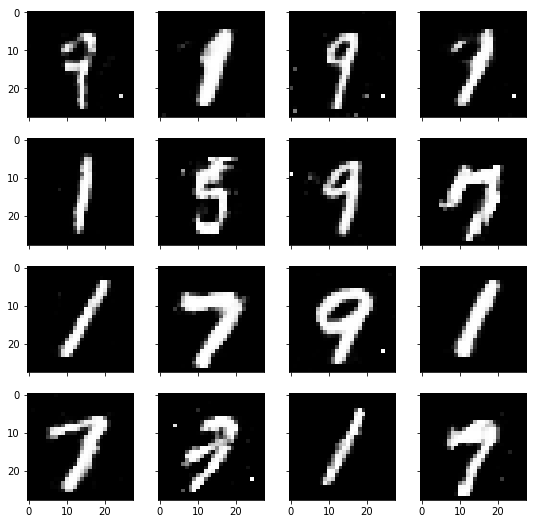

In [35]:
with graph.as_default():
    savere = tf.train.Saver()
with tf.Session(graph = graph) as sess:
    checkpoint = './checkpoints/generatorg.ckpt'
    savere.restore(sess, checkpoint)
    sample_z = np.random.uniform(-1, 1, size=((16, 100)))
    sample_z = tf.to_float(sample_z)
    gen_samples = sess.run(
                   generator_forward(sample_z, input_size, n_units=g_hidden_size, reuse=True, alpha=0.01))
                   #feed_dict={gen: sample_z})
view_samples(0, [gen_samples])